In [13]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_109733/2008134232.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

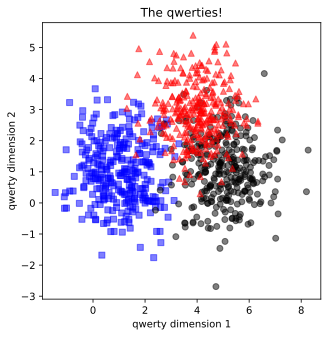

In [14]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [15]:
dropout_rate = 0.1

In [16]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# The model

In [17]:
# create a class for the model
def createTheQwertyNet(initialLR, num_epochs=50, batch_size=50):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

      # Dropout layer
      self.dropout = nn.Dropout(dropout_rate)

      # LeakyReLU activation
      self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    # forward pass
    def forward(self,x):
      x = self.dropout(self.leaky_relu(self.input(x)))
      x = self.dropout(self.leaky_relu(self.fc1(x)))
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer and LR scheduler
  optimizer = torch.optim.SGD(net.parameters(),
                              lr=initialLR, 
                              momentum=0.9, 
                              weight_decay=1e-4  # L2 regularization
                             )
  stepsize  = batchsize*len(train_loader)
  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)
  scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=0.1,  # Will reduce learning rate to 10% of initial value
        total_iters=num_epochs*batch_size
  )

  return net,lossfun,optimizer,scheduler

In [18]:
# Calculate the number of steps until the learning rate changes
steps_until_change = len(train_loader) * batchsize
print(steps_until_change)

# Explanation:
# We calculate the number of steps or iterations that will be performed in the training process until the learning rate changes. This calculation is based on the length of the 'train_loader,' which represents the training data divided into batches, and 'batchsize,' which specifies the size of each batch.

# For example, if there are 100 batches in the 'train_loader' and each batch contains 16 samples (as specified by 'batchsize'), then there will be a total of 100 * 16 = 1600 steps or iterations until the learning rate changes. This value indicates how many updates the model parameters will undergo before the learning rate scheduler takes effect and adjusts the learning rate.


800


# Explore the learning rate decay parameter

In [19]:
# Create a network
net = createTheQwertyNet(0.01)[0]

# Explanation:
# We create a neural network model called 'net' using the 'createTheQwertyNet' function with a specified L2 regularization strength of 0.01. The '[0]' at the end of the function call indicates that we are interested in the model itself, not the loss function or optimizer.

# Create a new optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/2)

# Explanation:
# We define a new optimizer for our neural network model. In this case, we use Stochastic Gradient Descent (SGD) as the optimization algorithm with a learning rate of 0.01. Additionally, we create a learning rate scheduler called 'scheduler' using the 'torch.optim.lr_scheduler.StepLR' class. The scheduler reduces the learning rate during training to improve convergence. Here, it is configured to decrease the learning rate by half every 5 epochs.

# Test the change in learning rate
for epoch in range(3):
  for batchnum in range(10):
    print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
    scheduler.step()

# Explanation:
# We enter a loop where we iterate through training epochs and batches within each epoch.

# - For each epoch (in this case, we have 3 epochs), we loop through 10 batches (specified by 'range(10)').

# - Inside the batch loop, we print the batch number, epoch number, and the current learning rate using the 'scheduler.get_last_lr()' function. This function retrieves the most recent learning rate value determined by the scheduler.

# - After printing the information, we call 'scheduler.step()' to update the learning rate according to the scheduler's policy.

# The output shows how the learning rate changes over batches and epochs based on the scheduler's configuration.


Batch 0, epoch 0: LR=0.01
Batch 1, epoch 0: LR=0.01
Batch 2, epoch 0: LR=0.01
Batch 3, epoch 0: LR=0.01
Batch 4, epoch 0: LR=0.01
Batch 5, epoch 0: LR=0.005
Batch 6, epoch 0: LR=0.005
Batch 7, epoch 0: LR=0.005
Batch 8, epoch 0: LR=0.005
Batch 9, epoch 0: LR=0.005
Batch 0, epoch 1: LR=0.0025
Batch 1, epoch 1: LR=0.0025
Batch 2, epoch 1: LR=0.0025
Batch 3, epoch 1: LR=0.0025
Batch 4, epoch 1: LR=0.0025
Batch 5, epoch 1: LR=0.00125
Batch 6, epoch 1: LR=0.00125
Batch 7, epoch 1: LR=0.00125
Batch 8, epoch 1: LR=0.00125
Batch 9, epoch 1: LR=0.00125
Batch 0, epoch 2: LR=0.000625
Batch 1, epoch 2: LR=0.000625
Batch 2, epoch 2: LR=0.000625
Batch 3, epoch 2: LR=0.000625
Batch 4, epoch 2: LR=0.000625
Batch 5, epoch 2: LR=0.0003125
Batch 6, epoch 2: LR=0.0003125
Batch 7, epoch 2: LR=0.0003125
Batch 8, epoch 2: LR=0.0003125
Batch 9, epoch 2: LR=0.0003125


# Training

In [20]:
# a function that trains the model

def function2trainTheModel(initialLR,toggleDynamicLR):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer,scheduler = createTheQwertyNet(initialLR, num_epochs=numepochs, batch_size=len(train_loader))

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  currentLR = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # step the learning-rate scheduler
      if toggleDynamicLR:
        scheduler.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies

      currentLR.append( scheduler.get_last_lr()[0] )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,currentLR


# Test that the model really changes (sanity checks)

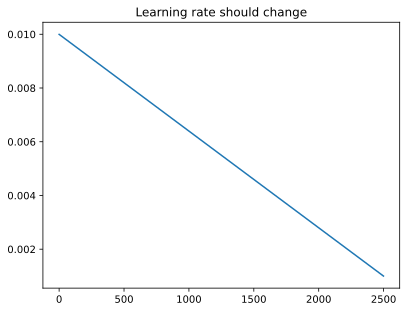

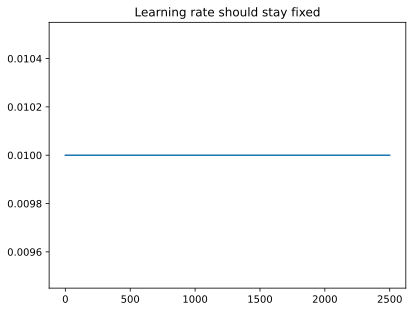

In [21]:
# test that the learning rate is really working
trainAcc,testAcc,losses,net,currentLR = function2trainTheModel(.01,True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()

trainAcc,testAcc,losses,net,currentLR = function2trainTheModel(.01,False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')
plt.show()

# Now for the experiment!

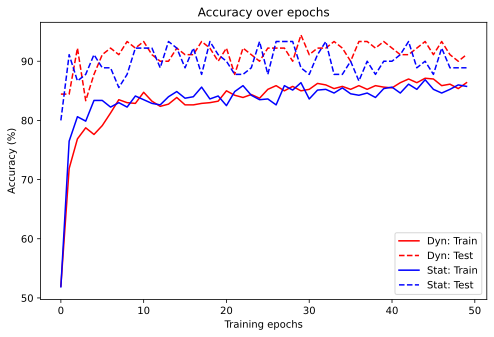

In [22]:
# now test with and without dynamic LR
trainAccDynamic,testAccDynamic,losses,net,currentLR = function2trainTheModel(.01,True)
trainAccStatic,testAccStatic,losses,net,currentLR   = function2trainTheModel(.01,False)

fig = plt.figure(figsize=(8,5))
plt.plot(trainAccDynamic,'r',label='Dyn: Train')
plt.plot(testAccDynamic,'r--',label='Dyn: Test')

plt.plot(trainAccStatic,'b',label='Stat: Train')
plt.plot(testAccStatic,'b--',label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


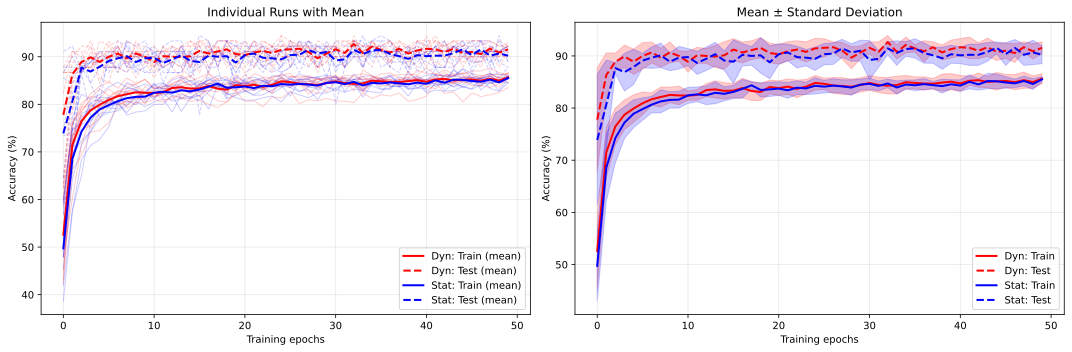

In [23]:
n_runs=10

# Arrays to store results from all runs
trainAcc_dynamic_all = []
testAcc_dynamic_all = []
trainAcc_static_all = []
testAcc_static_all = []

# Run training multiple times
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    
    # Train with dynamic learning rate
    trainAccDynamic, testAccDynamic, losses, net, currentLR = function2trainTheModel(.01, True)
    trainAcc_dynamic_all.append(trainAccDynamic)
    testAcc_dynamic_all.append(testAccDynamic)
    
    # Train with static learning rate
    trainAccStatic, testAccStatic, losses, net, currentLR = function2trainTheModel(.01, False)
    trainAcc_static_all.append(trainAccStatic)
    testAcc_static_all.append(testAccStatic)

# Convert to numpy arrays for easier computation
trainAcc_dynamic_all = np.array(trainAcc_dynamic_all)
testAcc_dynamic_all = np.array(testAcc_dynamic_all)
trainAcc_static_all = np.array(trainAcc_static_all)
testAcc_static_all = np.array(testAcc_static_all)

# Calculate means and standard deviations
train_dyn_mean = np.mean(trainAcc_dynamic_all, axis=0)
test_dyn_mean = np.mean(testAcc_dynamic_all, axis=0)
train_static_mean = np.mean(trainAcc_static_all, axis=0)
test_static_mean = np.mean(testAcc_static_all, axis=0)

train_dyn_std = np.std(trainAcc_dynamic_all, axis=0)
test_dyn_std = np.std(testAcc_dynamic_all, axis=0)
train_static_std = np.std(trainAcc_static_all, axis=0)
test_static_std = np.std(testAcc_static_all, axis=0)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Individual runs with transparency
for i in range(n_runs):
    # Dynamic learning rate runs
    ax1.plot(trainAcc_dynamic_all[i], 'r', alpha=0.2, linewidth=1)
    ax1.plot(testAcc_dynamic_all[i], 'r--', alpha=0.2, linewidth=1)
    
    # Static learning rate runs
    ax1.plot(trainAcc_static_all[i], 'b', alpha=0.2, linewidth=1)
    ax1.plot(testAcc_static_all[i], 'b--', alpha=0.2, linewidth=1)

# Add means to the first plot
ax1.plot(train_dyn_mean, 'r', label='Dyn: Train (mean)', linewidth=2)
ax1.plot(test_dyn_mean, 'r--', label='Dyn: Test (mean)', linewidth=2)
ax1.plot(train_static_mean, 'b', label='Stat: Train (mean)', linewidth=2)
ax1.plot(test_static_mean, 'b--', label='Stat: Test (mean)', linewidth=2)

# Plot 2: Means with standard deviation bands
epochs = range(len(train_dyn_mean))

# Dynamic learning rate
ax2.plot(train_dyn_mean, 'r', label='Dyn: Train', linewidth=2)
ax2.fill_between(epochs, 
                train_dyn_mean - train_dyn_std, 
                train_dyn_mean + train_dyn_std, 
                color='r', alpha=0.2)

ax2.plot(test_dyn_mean, 'r--', label='Dyn: Test', linewidth=2)
ax2.fill_between(epochs, 
                test_dyn_mean - test_dyn_std, 
                test_dyn_mean + test_dyn_std, 
                color='r', alpha=0.2)

# Static learning rate
ax2.plot(train_static_mean, 'b', label='Stat: Train', linewidth=2)
ax2.fill_between(epochs, 
                train_static_mean - train_static_std, 
                train_static_mean + train_static_std, 
                color='b', alpha=0.2)

ax2.plot(test_static_mean, 'b--', label='Stat: Test', linewidth=2)
ax2.fill_between(epochs, 
                test_static_mean - test_static_std, 
                test_static_mean + test_static_std, 
                color='b', alpha=0.2)

# Customize plots
for ax in [ax1, ax2]:
    ax.set_xlabel('Training epochs')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

ax1.set_title('Individual Runs with Mean')
ax2.set_title('Mean ± Standard Deviation')

plt.tight_layout()
plt.show()

# Additional explorations

In [24]:
# 1) When you run the experiment in the previous cell multiple times, you can get different answers. This indicates
#    that the network and/or training regimen is not stable enough. What can you do to increase the stability of the
#    model and training? That is, what can you change to make the results more similar each time you re-run the experiment?
# 
# 2) There are several more options for dynamic learning rates in Pytorch. Try modifying the code!
#       See https://pytorch.org/docs/stable/optim.html
# 